# 1. Program Setting
## 1.1 Program Arguments

In [1]:
dir_data = '../data/skin-cancer'
dir_ckpt = './outputs/ckpt'
dir_figure = './outputs/figures'

seed = 0
method = 'betti-curve'
n_bins = 100

n_classes = 7
input_shape = {'img': (28, 28, 1), 'tda': (n_bins, 2)}

## 1.2 Importing Libraries

In [2]:
import sys
sys.path.append('../')

from cnntdanet.utils import seed_all
from cnntdanet.tda import get_tda_pipeline
from cnntdanet.models import get_cnn_net, get_cnn_tda_net
from cnntdanet.utils.plotting import plot_learning_curve
from cnntdanet.gradcam import GradCAMOnCNN, GradCAMOnCNNTDANet

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

## 1.3 Configuration

In [3]:
seed_all(seed)

plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

In [4]:
# Preparing dataset
df = pd.read_csv(os.path.join(dir_data, 'hmnist_28_28_L.csv'))

X = df.drop('label', axis=1).values.reshape((-1, *input_shape['img']))
X = X.astype(np.float32)
X /= 255.0

y = df['label'].values
y = y.astype(np.int64)

## TDA features
pipeline = get_tda_pipeline(method=method, n_bins=n_bins)

X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

In [5]:
# Splitting data
train_indices, valid_indices = train_test_split(np.arange(len(X)), stratify=y, test_size=0.2, random_state=seed)

X_img_train, X_tda_train, y_train = X[train_indices], X_tda[train_indices], y[train_indices]
X_img_valid, X_tda_valid, y_valid = X[valid_indices], X_tda[valid_indices], y[valid_indices]

# GradCAM

## Loading model and Grad-CAM

In [6]:
cnn = tf.keras.models.load_model(os.path.join(dir_ckpt, 'hmnist_cnn_seed0'))
cnntda = tf.keras.models.load_model(os.path.join(dir_ckpt, 'hmnist_cnn_tda_seed0'))

2022-11-04 12:20:10.361754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
gradcam_cnn = GradCAMOnCNN(cnn, 'conv2d_3')
gradcam_cnntda = GradCAMOnCNNTDANet(cnntda, 'conv2d_8', 'conv1d_8')
label_decoder = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'nv',
    5: 'vasc',
    6: 'mel',
}

In [8]:
def select_topk_feature_maps(cache, k=5):
    """
    """
    img = cache['img']
    heatmap = cache['heatmap'][0]
    feature_maps = cache['feature_maps'][0]
    grad_maps = cache['grad_maps'][0]
    pooled_grads = np.mean(grad_maps, axis=(0, 1))
    topk_indices = np.argsort(-pooled_grads)[:k]

    return feature_maps[:, :, topk_indices]
    
    
def feature_to_image(fmap, width, height):
    if not isinstance(fmap, np.ndarray):
        fmap = fmap = numpy()
    fmap = fmap[..., np.newaxis]
    fmap = np.uint(255 * fmap)
    
    fmap = tf.keras.preprocessing.image.array_to_img(fmap)
    fmap = fmap.resize((width, height))
    fmap = tf.keras.preprocessing.image.img_to_array(fmap)
    
    return fmap


In [9]:
def filtration_to_image(img, filt_start, filt_end=None):
    if filt_end is None:
        mask = np.where(img != filt_start)
        
    else:
        mask = np.where((img < filt_start) | (img >= filt_end))
        
    inverse_img = img.copy()
    inverse_img[mask] = 0
    
    return inverse_img
        
    
def get_inverse_image(cache, l):
    img = cache['img'] / 255.0
    heatmap = cache['heatmap'][1][:, 0]
    argmax = np.argmax(heatmap)
    filt_start = max(0, argmax - l) / len(heatmap)
    filt_end = min(len(heatmap), argmax + 1) / len(heatmap)
    
    img_recovered = filtration_to_image(img, filt_start, filt_end)
    
    return img_recovered

6
6


/tmp/ipykernel_2914944/2285936160.py:117: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_tda.set_yticklabels([f'{i}' for i in ax_tda.get_yticks().astype(int)] ,fontsize=12)


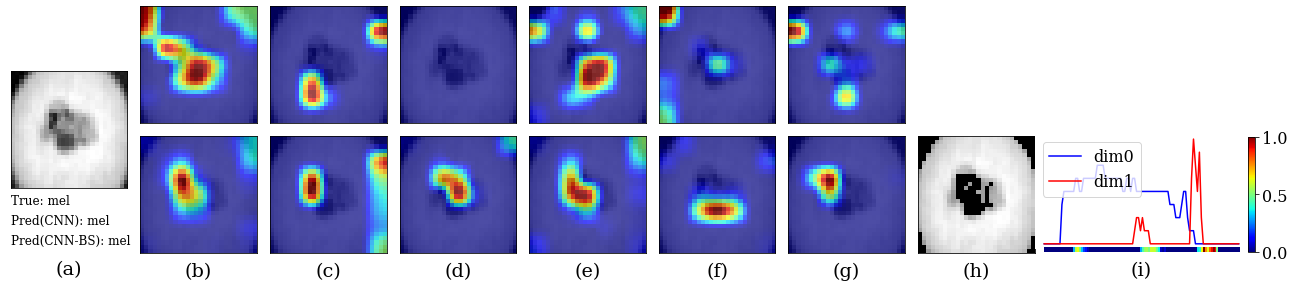

In [16]:
idx = 10
for idx in [25]:

    alpha = 0.7

    gradcam_cnn.to_heatmap(X_img_valid[idx])
    gradcam_cnntda.to_heatmap([X_img_valid[idx:idx+1], X_tda_valid[idx:idx+1]])

    cache1 = gradcam_cnn._cache
    cache2 = gradcam_cnntda._cache 

    print(cache1['pred_label'])
    print(cache2['pred_label'])

    topk1 = select_topk_feature_maps(cache1, 5)
    topk2 = select_topk_feature_maps(cache2, 5)

    fig = plt.figure(figsize=(18, 4))

    ax = fig.add_axes(rect=[0.01, 0.275, 0.09, 0.5])
    ax.imshow(cache1['img'], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('(a)', y=-0.795)

    ax = fig.add_axes(rect=[0.01, 0.25, 0.05, 0.05])
    ax.axis('off')
    ax.annotate(f'True: {label_decoder[y_valid[idx]]}', xy=(0.0, 0.0), xytext=(0.0, 5.0), xycoords='axes points' , fontsize=12)
    ax.annotate(f"Pred(CNN): {label_decoder[cache1['pred_label']]}", xy=(0.0, -15.0), xycoords='axes points' , fontsize=12)
    ax.annotate(f"Pred(CNN-BS): {label_decoder[cache2['pred_label']]}", xy=(0.0, -35.0), xycoords='axes points' , fontsize=12)

    ##
    ax = fig.add_axes(rect=[0.11, 0.5, 0.09, 0.5])
    ax.imshow(cache1['img'], cmap='gray')
    ax.imshow(cache1['heatmap'][0], cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])

    ax = fig.add_axes(rect=[0.11, 0.05, 0.09, 0.5])
    ax.imshow(cache2['img'], cmap='gray')
    ax.imshow(cache2['heatmap'][0], cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('(b)', y=-0.25)

    ##
    ax = fig.add_axes(rect=[0.21, 0.5, 0.09, 0.5])
    ax.imshow(cache1['img'], cmap='gray')
    ax.imshow(feature_to_image(topk1[:, :, 0], 28, 28), cmap='jet', alpha=alpha) 
    ax.set_xticks([]); ax.set_yticks([])

    ax = fig.add_axes(rect=[0.21, 0.05, 0.09, 0.5])
    ax.imshow(cache2['img'], cmap='gray')
    ax.imshow(feature_to_image(topk2[:, :, 0], 28, 28), cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('(c)', y=-0.25)

    ##
    ax = fig.add_axes(rect=[0.31, 0.5, 0.09, 0.5])
    ax.imshow(cache1['img'], cmap='gray')
    ax.imshow(feature_to_image(topk1[:, :, 1], 28, 28), cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])

    ax = fig.add_axes(rect=[0.31, 0.05, 0.09, 0.5])
    ax.imshow(cache2['img'], cmap='gray')
    ax.imshow(feature_to_image(topk2[:, :, 1], 28, 28), cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('(d)', y=-0.25)

    ##
    ax = fig.add_axes(rect=[0.41, 0.5, 0.09, 0.5])
    ax.imshow(cache1['img'], cmap='gray')
    ax.imshow(feature_to_image(topk1[:, :, 2], 28, 28), cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])

    ax = fig.add_axes(rect=[0.41, 0.05, 0.09, 0.5])
    ax.imshow(cache2['img'], cmap='gray')
    ax.imshow(feature_to_image(topk2[:, :, 2], 28, 28), cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('(e)', y=-0.25)

    ##
    ax = fig.add_axes(rect=[0.51, 0.5, 0.09, 0.5])
    ax.imshow(cache1['img'], cmap='gray')
    ax.imshow(feature_to_image(topk1[:, :, 3], 28, 28), cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])

    ax = fig.add_axes(rect=[0.51, 0.05, 0.09, 0.5])
    ax.imshow(cache2['img'], cmap='gray')
    ax.imshow(feature_to_image(topk2[:, :, 3], 28, 28), cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('(f)', y=-0.25)

    ##
    ax = fig.add_axes(rect=[0.61, 0.5, 0.09, 0.5])
    ax.imshow(cache1['img'], cmap='gray')
    ax.imshow(feature_to_image(topk1[:, :, 4], 28, 28), cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])

    ax = fig.add_axes(rect=[0.61, 0.05, 0.09, 0.5])
    ax.imshow(cache2['img'], cmap='gray')
    ax.imshow(feature_to_image(topk2[:, :, 4], 28, 28), cmap='jet', alpha=alpha)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('(g)', y=-0.25)

    ##
    img_recovered = get_inverse_image(gradcam_cnntda._cache, l=32)

    ax = fig.add_axes(rect=[0.71, 0.05, 0.09, 0.5])
    ax.imshow(cache2['img'], cmap='gray')
    ax.imshow(img_recovered, cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('(h)', y=-0.25)

    ##
    ax_tda = fig.add_axes(rect=[0.80, 0.11, 0.165, 0.40])
    ax_tda.plot(cache2['tda'][:, 0], 'b', label='dim0')
    ax_tda.plot(cache2['tda'][:, 1], 'r', label='dim1')
    ax_tda.set_xticks(np.arange(0, 101, 10), [f'{0.1 * i:.1f}' for i in range(11)], fontsize=12, rotation=60)
    ax_tda.set_yticklabels([f'{i}' for i in ax_tda.get_yticks().astype(int)] ,fontsize=12)
    ax_tda.set_xticks([]); ax_tda.set_yticks([]);
    ax_tda.spines['bottom'].set_visible(False)
    ax_tda.spines['top'].set_visible(False)
    ax_tda.spines['left'].set_visible(False)
    ax_tda.spines['right'].set_visible(False)
    ax_tda.legend(loc=2); ax_tda.grid();
    #  ax_tda.set_title('Grad-CAM on CNN-TDA Net (Betti curve)', y=1.02)
    ax_tda.set_title('(i)', y=-0.28)

    ax_mat = fig.add_axes([0.8075, -0.3415, 0.151, 0.9])
    mat = ax_mat.matshow(cache2['heatmap'][1].T, cmap='jet')
    ax_mat.axis('off')

    cax = fig.add_axes([0.965, 0.1, 0.005, 0.4])
    fig.colorbar(mat, cax=cax)

    plt.savefig(f'{dir_figure}/result_ham_{idx}.pdf')

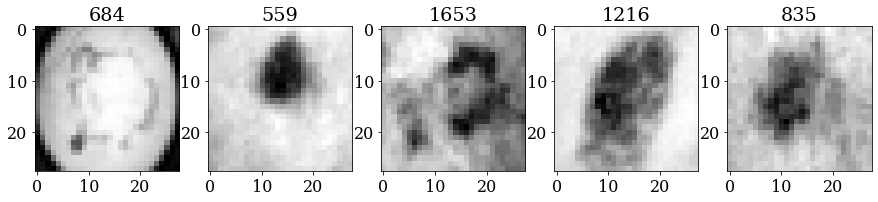

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for k, i in enumerate(np.random.choice(np.arange(len(y_valid)), 5)):
    axes[k].imshow(X_img_valid[i], cmap='gray')
    
    axes[k].set_title(i)